In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

np.random.seed(14)

In [2]:
def lin2db(x):
    return 10.0*np.log10(x)

def db2lin(x):
    return 10.0**(x/10.0)

def lin2dbm(x):
    return 10.0*np.log10(x)+30.0

def dbm2lin(x):
    return 10.0**(x/10.0 - 3.0)

In [3]:
def eCDF(data):
    x = np.sort(data)
    y = np.arange(0, len(data)) / len(data)

    return x, y 

In [4]:
total_bandwidth = 100e6 # [Hz]

environment_constant = 1e-4
pathloss_constant = 4

ref_distance = 1 # [m]

In [5]:
def random_ue_positions(num_ue, cov_side):
    ''' 
    Returns a random position vector within the coverage area.
    
    Parameters
    ----------
    cov_side : int, float
        The side [in m] of the coverage area.
    num_ue : int
        The number of UEs.
    '''
    
    ue_positions = np.zeros((num_ue, 2))
    
    for ue in range(num_ue):
        ue_positions[ue] = [np.random.rand() * cov_side, np.random.rand() * cov_side]
        
    return ue_positions

In [6]:
def ap_positions(num_ap, cov_side):
    ''' 
    Returns the APs positions based on the number of APs.
    
    Parameters
    ----------
    num_ap : int
        The number of APs.
    cov_side : int, float
        The side [in m] of coverage area.
    '''
    
    if np.sqrt(num_ap).is_integer():
        
        side_ap_quantity = int(np.sqrt(num_ap))
        
        ap_area_side = cov_side // side_ap_quantity
        
        x_pos, y_pos = np.meshgrid(np.arange(0.5 * ap_area_side,
                                             cov_side,
                                             ap_area_side),
                                   np.arange(0.5 * ap_area_side,
                                             cov_side,
                                             ap_area_side))
 
        aps_pos = np.column_stack((x_pos.ravel(), y_pos.ravel()))
    
        return aps_pos
    
    else:
        
        print('Number of APs must be a perfect square')

In [7]:
def distance(ue_pos, ap_pos, ref_distance=1):
    ''' 
    Returns the distance [in m] between an UE and an AP. If distance is lower than reference distance, it returns the reference distance.
    
    Parameters
    ----------
    ue_pos : int, float
        The UE position.
    ap_pos : int, float
        The AP position.
    ref_distance : int, float
        The reference distance [in m] from which the gain is calculated.
    '''

    dis_matrix = np.zeros((ue_pos.shape[0], ap_pos.shape[0]))
    
    for ue in range(ue_pos.shape[0]):
        for ap in range(ap_pos.shape[0]):
            dis = np.sqrt(((ue_pos[ue])[0] - (ap_pos[ap])[0])**2
                          + ((ue_pos[ue])[1] - (ap_pos[ap])[1])**2)

            if dis >= ref_distance:
                dis_matrix[ue, ap] = dis
            else:
                dis_matrix[ue, ap] = ref_distance

    return dis_matrix

In [8]:
def shadowing(std, num_ue, num_ap):

    return np.random.lognormal(sigma = std, size = (num_ue, num_ap))

In [9]:
def rayleigh(std, num_ue, num_ap):

    return np.sqrt((std*np.random.randn(num_ue, num_ap))**2 + (std*np.random.randn(num_ue, num_ap))**2) 

In [10]:
def multipath_channel(distance, shadowing, rayleigh):

    return shadowing * (environment_constant / (distance ** pathloss_constant)) * rayleigh**2

In [11]:
def rx_power(channel, tx_power):
    
    power_vector = np.zeros(channel.shape)
    
    for ue in range(channel.shape[0]):

        max_index = np.where(channel[ue, :] == channel[ue, :].max())
        power_vector[ue][max_index] = tx_power[ue] * channel[ue, :].max()
        
    return power_vector

In [12]:
def sinr(power_vector, channel, power_noise):
    
    sinr_matrix = np.zeros(channel.shape)
    sinr_vector = np.zeros(channel.shape[0])
    
    for col in range(channel.shape[1]):

        channel_sum = 0
        
        for row in range(channel.shape[0]):

            channel_sum += np.abs(channel[row, col]) * power_vector[row]

        for row in range(channel.shape[0]):

            interest_channel = power_vector[row] * np.abs(channel[row, col])

            sinr_matrix[row, col] = interest_channel / ((channel_sum - interest_channel) + power_noise)

    for row in range(channel.shape[0]):

        sinr_vector[row] = sinr_matrix[row].max()

    return lin2db(sinr_vector)

In [37]:
def ud_dpc(sinr_target, p_max, p_min, step, channel, total_time):

    power_vector = np.ones((1, channel.shape[0])).T
    sinr_vector = np.zeros((1, channel.shape[0])).T

    time = 0

    while time <= total_time:

        sinr_vector = db2lin(sinr(power_vector.T[0], channel, noise_p))
        
        power_vector = power_vector + (step * np.sign(sinr_target - sinr_vector)).reshape(power_vector.shape)
        
        for p in range(power_vector.shape[0]):

            if power_vector[p] > p_max:

                power_vector[p] = p_max

            if power_vector[p] < p_min:

                power_vector[p] = p_min

        time += 1
    
    return power_vector.T[0]

In [14]:
def capacity(total_bandwidth, sinr):
    
    return (total_bandwidth * np.log2(1 + db2lin(sinr))) / 1e6

In [15]:
def power_noise(total_bandwidth):
    
    return total_bandwidth * 1e-20

In [64]:
num_ue = 4
num_ap = 4
cov_side = 1000 # [m]
seeds = 1000

sh_std = 2
mp_std = 1 / np.sqrt(2) 

noise_p = power_noise(total_bandwidth)

In [50]:
sinr_target = 1
p_max = 1
p_min = 1e-3
step = 1e-3
total_time = 100

In [69]:
def simulation(num_ue):

    ud_total_sinr = np.zeros((num_ue, seeds))
    npc_total_sinr = np.zeros((num_ue, seeds))
    
    ud_total_capacity = np.zeros((num_ue, seeds))
    npc_total_capacity = np.zeros((num_ue, seeds))
    
    for seed in range(seeds):
        
        #ue_pos = random_ue_positions(num_ue, cov_side)

        ue_pos = np.array([[225.83, 203.33], [566.79, 321.88], [765.51, 146.88], [265.95, 702.39]])
        
        ap_pos = ap_positions(num_ap, cov_side)
        distances = distance(ue_pos, ap_pos)
        
        #shadowing_matrix = shadowing(sh_std, num_ue, num_ap)
        #rayleigh_matrix = rayleigh(mp_std, num_ue, num_ap)

        shadowing_matrix = np.array([[5.3434e-2, 2.8731e-1, 1.9691e-2, 7.3013e-1], [3.2318, 1.5770, 2.6449e-1, 5.6379], 
                                     [6.1470e-3, 1.1424, 2.6826e-1, 4.5709], [1.3485e-1, 4.6690e-1, 7.8250e-1, 1.6742]])
    
        rayleigh_matrix = np.array([[1.248699, 3.248041, 0.772754, 0.708962], [0.498887, 0.104890, 0.647280, 0.940906], 
                                     [0.382966, 0.6827, 1.891256, 0.3271], [0.065737, 0.6495, 1.981107, 1.259538]])

        
        channel_matrix = multipath_channel(distances, shadowing_matrix, rayleigh_matrix)

        print(channel_matrix)
        
        ud_power = ud_dpc(sinr_target, p_max, p_min, step, channel_matrix, total_time)
        npc_power = np.ones(num_ue)

        ud_total_sinr[:, seed] = sinr(ud_power, channel_matrix, noise_p)
        npc_total_sinr[:, seed] = sinr(npc_power, channel_matrix, noise_p)
        
        ud_total_capacity[:, seed] = capacity(total_bandwidth, sinr(ud_power, channel_matrix, noise_p))
        npc_total_capacity[:, seed] = capacity(total_bandwidth, sinr(npc_power, channel_matrix, noise_p))

        clear_output(wait=True)


    return ud_total_sinr, npc_total_sinr, ud_total_capacity, npc_total_capacity

In [70]:
sim = simulation(num_ue)

[[1.09193933e-12 3.95226987e-15 1.31145402e-17 1.11538391e-16]
 [7.22366450e-15 1.15650017e-15 1.37736994e-16 1.06140327e-14]
 [1.18020358e-18 4.50272910e-13 2.42135888e-16 3.69125166e-16]
 [1.38784090e-18 1.02218637e-16 4.83186772e-11 4.74576747e-15]]


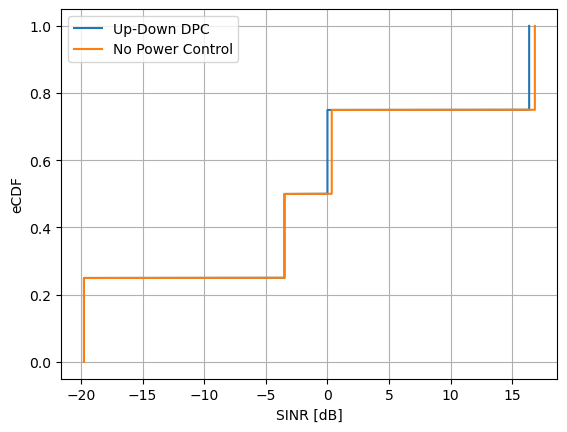

In [71]:
sinr_cdf_ud = eCDF(sim[0].flatten())
plt.plot(sinr_cdf_ud[0], sinr_cdf_ud[1], label='Up-Down DPC')

sinr_cdf_npc = eCDF(sim[1].flatten())
plt.plot(sinr_cdf_npc[0], sinr_cdf_npc[1], label='No Power Control')

plt.xlabel('SINR [dB]')
plt.ylabel('eCDF')

plt.legend()
plt.grid()

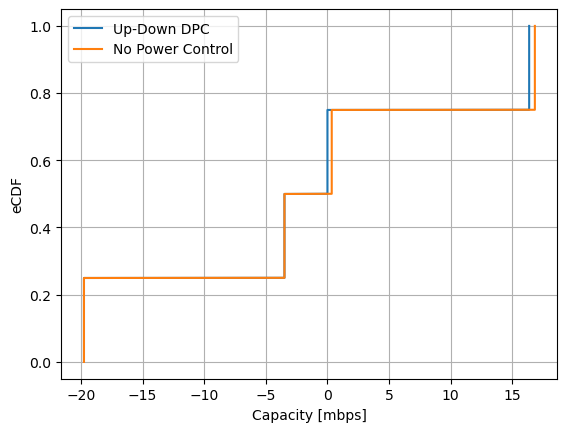

In [72]:
capacity_cdf_ud = eCDF(sim[0].flatten())
plt.plot(capacity_cdf_ud[0], capacity_cdf_ud[1], label='Up-Down DPC')

capacity_cdf_npc = eCDF(sim[1].flatten())
plt.plot(capacity_cdf_npc[0], capacity_cdf_npc[1], label='No Power Control')

plt.xlabel('Capacity [mbps]')
plt.ylabel('eCDF')

plt.legend()
plt.grid()